# STTAI - Lab Assignment 11

Name | Roll Number
---|---
Romit Mohane | 23110279
Rudra Pratap Singh | 23110281

This assignment aims to learn about model quantization.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

### 1. Dataset Preparation

In [2]:
!wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
!wget https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv

--2025-04-19 20:08:10--  https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720259 (703K) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>] 703.38K  --.-KB/s    in 0.02s   

2025-04-19 20:08:10 (35.7 MB/s) - ‘train.tsv’ saved [720259/720259]

--2025-04-19 20:08:11--  https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response...

> Load the training dataset and test data.

In [3]:
train_df = pd.read_csv('train.tsv', header= None, sep='\t')
test_df = pd.read_csv('test.tsv', header=None, sep='\t')
train_df.columns = ['sentence', 'label',]
test_df.columns = ['sentence', 'label',]

train_df.head()

,sentence,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


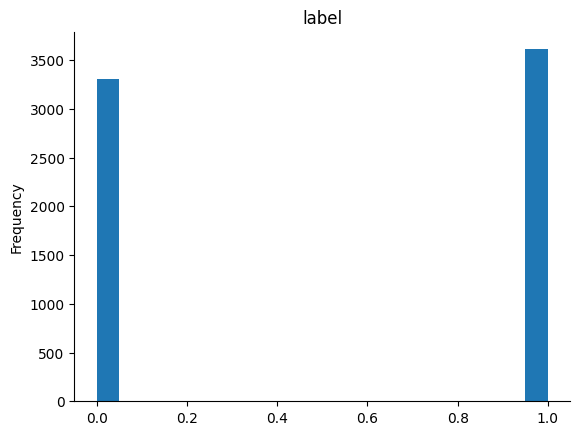

In [4]:
train_df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

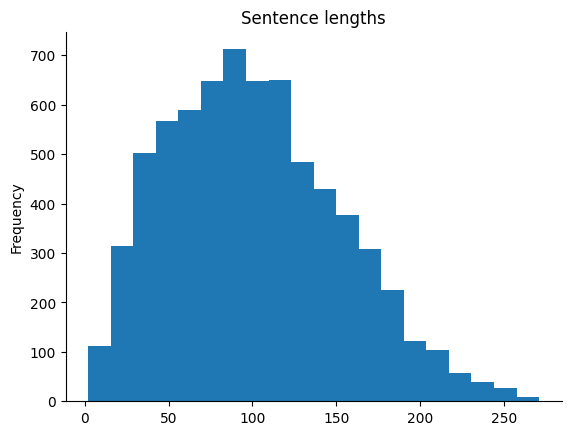

In [5]:
train_df['sentence'].str.len().plot(kind='hist', bins=20, title='Sentence lengths')
plt.gca().spines[['top', 'right',]].set_visible(False)

> Use 20% of the training dataset as the validation set.


In [6]:
train_df, val_df = tts(train_df, test_size=0.2)

train_df.shape, val_df.shape, test_df.shape

((5536, 2), (1384, 2), (1821, 2))

### 2. Construct a Multi-Layer Perceptron (MLP) model.

In [7]:
# Initialize Bag-of-Words vectorizer
vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_df['sentence']).toarray()
X_val = vectorizer.transform(val_df['sentence']).toarray()
y_train = train_df['label'].values
y_val = val_df['label'].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (5536, 10000)
X_val shape: (1384, 10000)


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_1=512,hidden_2=256,hidden_3=128,hidden_4=64, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.fc5 = nn.Linear(hidden_4, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x


Count the number of trainable parameters in the model using the automated function.

In [9]:
model = MLP(input_dim=10000)

# Count trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {num_params:,}")


Total trainable parameters: 5,293,122


### 3. Train the model with 10 epochs and create the best-performing model (checkpoint.pt)

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

Plot the validation accuracy + loss (epochs vs accuracy-loss).

Epoch 1 | Train Loss: 0.6101 | Val Loss: 10.4844 | Val Acc: 77.53%
Epoch 2 | Train Loss: 0.2710 | Val Loss: 10.3750 | Val Acc: 79.48%
Epoch 3 | Train Loss: 0.0789 | Val Loss: 16.5304 | Val Acc: 79.48%
Epoch 4 | Train Loss: 0.0190 | Val Loss: 19.3950 | Val Acc: 79.55%
Epoch 5 | Train Loss: 0.0058 | Val Loss: 28.1229 | Val Acc: 79.26%
Epoch 6 | Train Loss: 0.0013 | Val Loss: 36.2932 | Val Acc: 79.55%
Epoch 7 | Train Loss: 0.0015 | Val Loss: 37.6813 | Val Acc: 79.41%
Epoch 8 | Train Loss: 0.0005 | Val Loss: 42.6691 | Val Acc: 79.84%
Epoch 9 | Train Loss: 0.0002 | Val Loss: 45.3156 | Val Acc: 79.34%
Epoch 10 | Train Loss: 0.0010 | Val Loss: 45.9735 | Val Acc: 79.41%


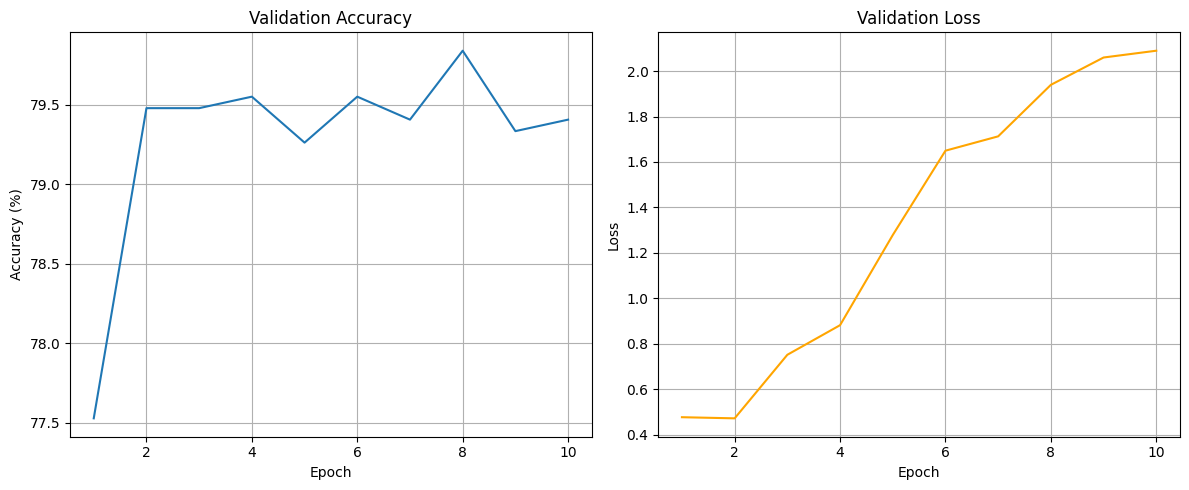

In [14]:
model = MLP(input_dim= X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
best_val_acc = 0.0
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2f}%")

    # Save best model
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), "checkpoint.pt")

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, 11), val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, 11), val_losses, label="Val Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import time
import os

model_fp32 = MLP(input_dim=X_train.shape[1])
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()


torch.save(model_fp32.state_dict(), "original_model.pt")
size_original_mb = os.path.getsize("original_model.pt") / (1024 * 1024)

# Inference
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
start = time.time()
with torch.no_grad():
    outputs = model_fp32(X_val_tensor)
    preds = torch.argmax(outputs, dim=1)
inference_time_ms = (time.time() - start) * 1000

# Accuracy
correct = (preds == torch.tensor(y_val)).sum().item()
accuracy_fp32 = 100 * correct / len(y_val)

print("Original Model Results:")
print(f"Accuracy: {accuracy_fp32:.2f}%")
print(f"Model Size: {size_original_mb:.2f} MB")
print(f"Inference Time: {inference_time_ms:.2f} ms")


Original Model Results:
Accuracy: 79.84%
Model Size: 20.20 MB
Inference Time: 136.51 ms


### 4. Now use:
  1. Dynamic Quantization with INT4 or INT8
  1. Half precision

In [19]:
model_fp32 = MLP(input_dim=X_train.shape[1])
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

# Apply dynamic quantization (INT8, not INT4)
model_dynamic = torch.quantization.quantize_dynamic(
    model_fp32, {nn.Linear}, dtype=torch.qint8
)

torch.save(model_dynamic.state_dict(), "dynamic_quantized.pt")
size_dynamic_mb = os.path.getsize("dynamic_quantized.pt") / (1024 * 1024)

# Inference
X_val_tensor_q = torch.tensor(X_val, dtype=torch.float32)
start = time.time()
with torch.no_grad():
    outputs = model_dynamic(X_val_tensor_q)
    preds = torch.argmax(outputs, dim=1)
inference_time_ms = (time.time() - start) * 1000

# Accuracy
correct = (preds == torch.tensor(y_val)).sum().item()
accuracy = 100 * correct / len(y_val)

print("Dynamic Quantization Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Model Size: {size_dynamic_mb:.2f} MB")
print(f"Inference Time: {inference_time_ms:.2f} ms")


Dynamic Quantization Results:
Accuracy: 80.06%
Model Size: 5.06 MB
Inference Time: 136.49 ms


In [20]:
model_fp32 = MLP(input_dim=X_train.shape[1])
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp16 = model_fp32.half()
model_fp16.eval()

X_val_tensor_fp16 = torch.tensor(X_val, dtype=torch.float16)


start = time.time()
with torch.no_grad():
    outputs = model_fp16(X_val_tensor_fp16)
    preds = torch.argmax(outputs, dim=1)
inference_time_fp16 = (time.time() - start) * 1000

# Accuracy
correct = (preds == torch.tensor(y_val)).sum().item()
accuracy_fp16 = 100 * correct / len(y_val)

torch.save(model_fp16.state_dict(), "half_precision.pt")
size_fp16_mb = os.path.getsize("half_precision.pt") / (1024 * 1024)

print("Half Precision Results:")
print(f"Accuracy: {accuracy_fp16:.2f}%")
print(f"Model Size: {size_fp16_mb:.2f} MB")
print(f"Inference Time: {inference_time_fp16:.2f} ms")


Half Precision Results:
Accuracy: 79.84%
Model Size: 10.10 MB
Inference Time: 1971.20 ms
